In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm 
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import sys
sys.path.append('..')
from utils.preprocess import NDF

2024-05-24 23:12:17.759730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Step 2: Training


In [2]:
input_data = {
    'benign': '../feature-extraction/floor/benign_2312.parquet',
    'malign': '../feature-extraction/floor/misp_2402.parquet'
}

dataset = NDF("xgboost", True, input_data=input_data, one_line_processing=False)
class_map = dataset['class_map']
print(dataset['feature_names'])

x_train, x_test, y_train, y_test = train_test_split(np.array(dataset['features']), np.array(dataset['labels']), test_size=0.2, random_state=42)


2024-05-24 23:12:22,454 - utils.preprocess - INFO - Benign dataset path: ../feature-extraction/floor/benign_2312.parquet
2024-05-24 23:12:22,458 - utils.preprocess - INFO - Malign dataset path: ../feature-extraction/floor/misp_2402.parquet


Malign dataset path: ../feature-extraction/floor/misp_2402.parquet
Benign dataset path: ../feature-extraction/floor/benign_2312.parquet


2024-05-24 23:12:24,330 - utils.preprocess - INFO - Number of records in benign dataset: 462192
2024-05-24 23:12:24,333 - utils.preprocess - INFO - Number of records in malign dataset: 110311
2024-05-24 23:12:29,067 - utils.preprocess - INFO - Total percentage of missing values in benign dataset: 0.19%
2024-05-24 23:12:29,073 - utils.preprocess - INFO - Total percentage of missing values in malign dataset: 0.33%
2024-05-24 23:12:31,168 - utils.preprocess - INFO - Decision tree model saved to models/malware_decision_tree_model.joblib
2024-05-24 23:12:31,252 - utils.preprocess - INFO - New feature 'dtree_prob' created from decision tree predictions.
2024-05-24 23:12:31,335 - utils.preprocess - INFO - Decision Tree Train Accuracy: 0.95
2024-05-24 23:12:31,337 - utils.preprocess - INFO - Decision Tree Test Accuracy: 0.92
2024-05-24 23:12:32,740 - utils.preprocess - INFO - Decision Tree Cross-Validation Scores: [0.91312094 0.91374974 0.9166754 ]
2024-05-24 23:12:32,742 - utils.preprocess - 


Dataset Subset:
Name: dataset_../feature-extraction/floor/benign2312_../feature-extraction/floor/misp2402_2024-05-24.parquet
Features:
   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0        0.0      0.125   0.000000        0.1   0.307692   0.076923   
1        0.0      0.125   0.000000        0.1   0.153846   0.230769   
2        0.0      0.125   0.000000        0.0   0.000000   0.000000   
3        1.0      0.000   0.000000        0.0   0.000000   0.000000   
4        0.0      0.000   0.000000        0.0   0.000000   0.000000   
5        0.0      0.250   0.333333        0.0   0.153846   0.000000   
6        1.0      0.125   0.000000        0.0   0.000000   0.000000   
7        0.0      0.000   0.000000        0.0   0.000000   0.000000   
8        0.0      0.125   0.000000        0.1   0.153846   0.153846   
9        0.0      0.250   0.333333        0.0   0.000000   0.000000   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_167  Feature_168  \
0 

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, average_precision_score

# Optimal parameters selected based on hyperparameter tuning
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
weight_for_0 = class_counts[1] / class_counts[0]  # Number of majority class / number of minority class

params = {
    "max_depth": 9,
    "eta": 0.2,
    "objective": "binary:logistic",
    "min_child_weight": 2.0,
    "subsample": 0.8,
    "alpha": 0.1,
    "gamma": 0.5,
    "lambda": 1.5,
    "max_delta_step": 1,
    "grow_policy": "lossguide",
    "max_bin": 256,
    "colsample_bytree": 0.8,
    "scale_pos_weight": weight_for_0  # Adjusting scale_pos_weight for class imbalance
}
trees = 300

model = XGBClassifier(
    **params,
    n_estimators=trees,
    eval_metric="logloss"  # Using logloss for training metric, as AUPRC cannot be directly used here
)

# Set to True to cross validate
do_cross_val = True
if do_cross_val:
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score

    # Define a custom scorer for AUPRC
    auprc_scorer = make_scorer(average_precision_score, needs_proba=True)
    
    kfold = StratifiedKFold(n_splits=40, shuffle=True, random_state=42)
    results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=auprc_scorer)  # Removed .numpy() assuming x_train and y_train are already suitable numpy arrays

# Train the model
eval_set = [(x_train, y_train), (x_test, y_test)]  # Assuming x_train, x_test, y_train, y_test are already numpy arrays
_ = model.fit(x_train, y_train, eval_set=eval_set, verbose=True)  # Verbose=True to see progress


/home/survivecz/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[0]	validation_0-logloss:0.41836	validation_1-logloss:0.41682
[1]	validation_0-logloss:0.37729	validation_1-logloss:0.37617
[2]	validation_0-logloss:0.34491	validation_1-logloss:0.34542
[3]	validation_0-logloss:0.31455	validation_1-logloss:0.31691
[4]	validation_0-logloss:0.28373	validation_1-logloss:0.28640
[5]	validation_0-logloss:0.25579	validation_1-logloss:0.25881
[6]	validation_0-logloss:0.23084	validation_1-logloss:0.23429
[7]	validation_0-logloss:0.20811	validation_1-logloss:0.21205
[8]	validation_0-logloss:0.18759	validation_1-logloss:0.19228
[9]	validation_0-logloss:0.17107	validation_1-logloss:0.17737
[10]	validation_0-logloss:0.15533	validation_1-logloss:0.16220
[11]	validation_0-logloss:0.14298	validation_1-logloss:0.15081
[12]	validation_0-logloss:0.13111	validation_1-logloss:0.13894
[13]	validation_0-logloss:0.12015	validation_1-logloss:0.12825
[14]	validation_0-logloss:0.11178	validation_1-logloss:0.12115
[15]	validation_0-logloss:0.10338	validation_1-logloss:0.11350
[1

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


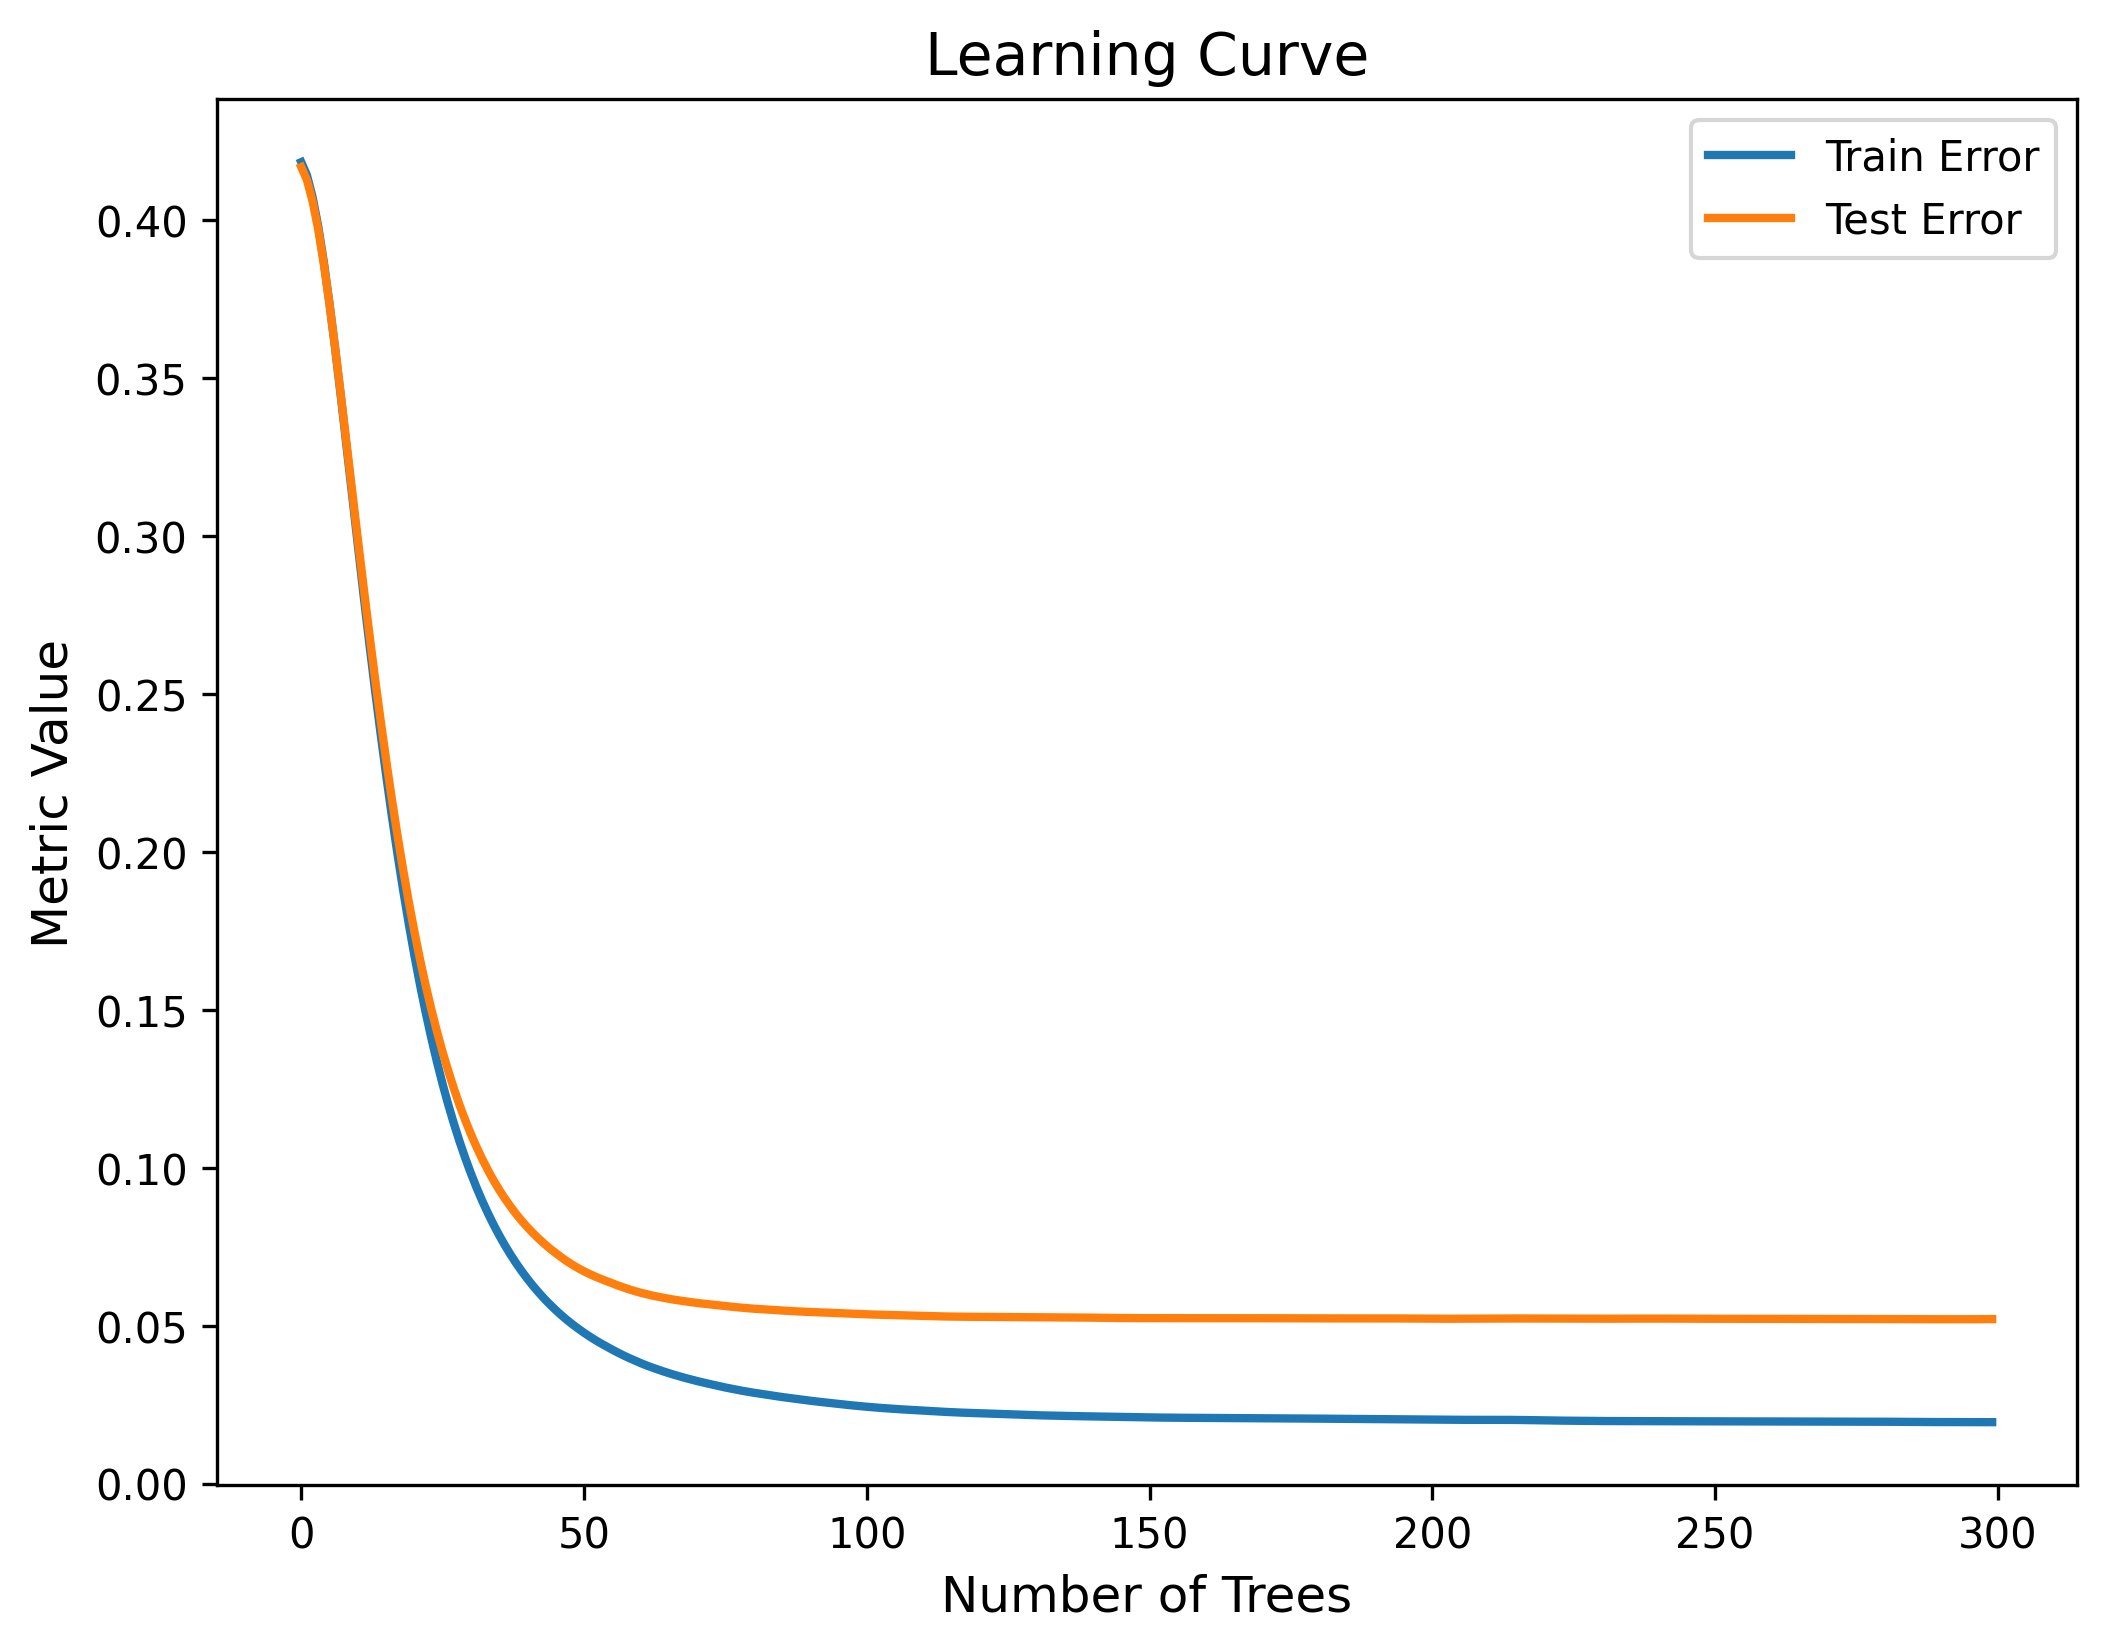

In [4]:
# plot evaluation
results = model.evals_result()
trees = len(results['validation_0']['logloss'])
x_axis = range(0, trees)

from matplotlib import style

print(plt.style.available)


# Smoothing function to reduce noise in the learning curve
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Updated function to plot the learning curve with smoothed lines
def plot_learning_curve(metric):
    # Apply modern look
    # plt.style.use('seaborn-v0_8-whitegrid')
    
    # Retrieve metric data
    train_metric = results['validation_0'][metric]
    test_metric = results['validation_1'][metric]
    
    # Apply smoothing to the metric data
    train_metric_smoothed = smooth_curve(train_metric)
    test_metric_smoothed = smooth_curve(test_metric)
    
    # Generate the plot with improved aesthetics
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    ax.plot(x_axis, train_metric_smoothed, label='Train Error', linewidth=2, color='tab:blue')
    ax.plot(x_axis, test_metric_smoothed, label='Test Error', linewidth=2, color='tab:orange')
    ax.legend()
    ax.set_xlabel('Number of Trees', fontsize=12)
    ax.set_ylabel('Error' if metric == 'error' else 'Metric Value', fontsize=12)
    ax.set_title('Learning Curve', fontsize=14)
    plt.show()

# Plotting the smoothed learning curve for 'error'
plot_learning_curve('logloss')

In [5]:
# import pickle
# pickle.dump(model, open("xgboost_model.pickle.dat", "wb"))

# # Save X_train to a pickle file
# with open('X_train.pickle.dat', 'wb') as file:
#   pickle.dump(X_train, file)

# # Save Y_train to a pickle file
# with open('y_train.pickle.dat', 'wb') as file:
#   pickle.dump(y_train, file)

# Step 3: Evaluating the model's performance

In [6]:
# import pickle
# model = pickle.load(open("xgboost_model.pickle.dat", "rb"))

0.9594053744997141


              precision    recall  f1-score   support

         0.0     0.9860    0.9979    0.9919      4383
         1.0     0.9894    0.9312    0.9594       901

    accuracy                         0.9866      5284
   macro avg     0.9877    0.9646    0.9757      5284
weighted avg     0.9866    0.9866    0.9864      5284



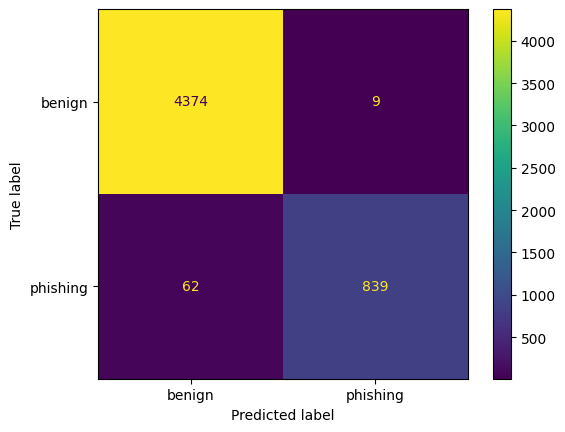

In [7]:
predicted = model.predict(x_test)

from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, predicted, digits=4))
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, display_labels=['benign', 'phishing'], values_format='d')

# Step 4: Explaining the model's predictions

### Feature Importance (directly extracted from the model)

XGBoost has a built-in function to plot feature importance directly. The variable `feature_importances` holds the importance scores derived from the machine learning model. These scores signify the contribution of each feature to the model's predictive performance.

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


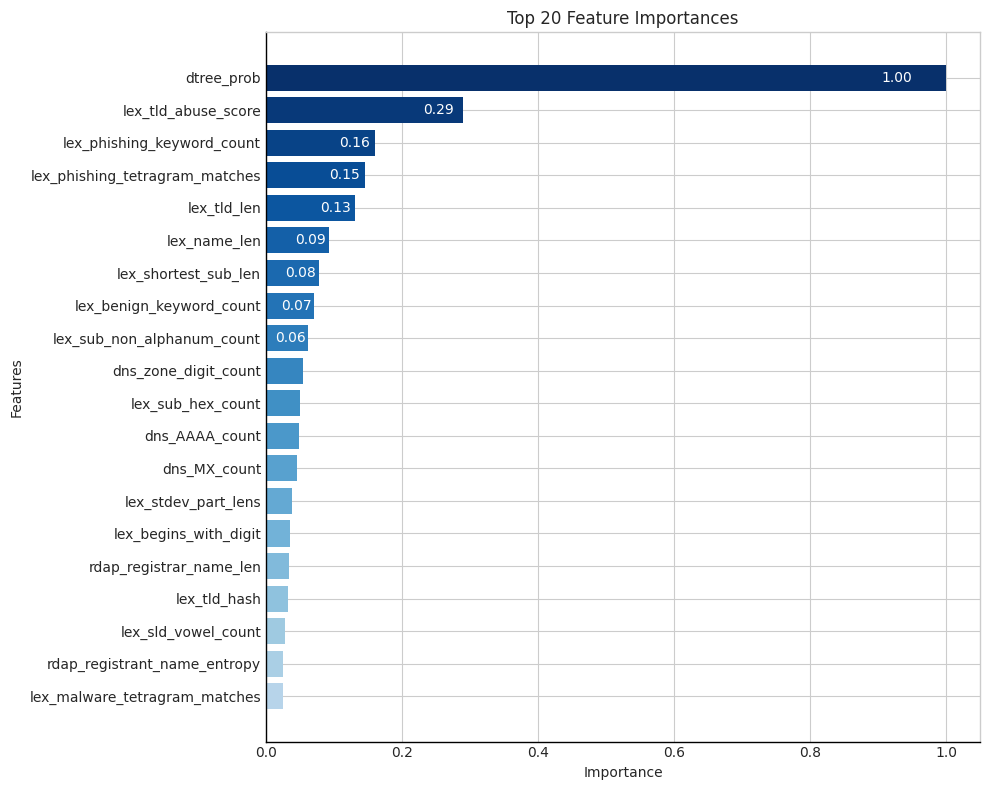

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

# Your data setup remains unchanged
feature_names = dataset['feature_names'] if 'feature_names' in dataset else [f"Feature {i}" for i in range(len(model.feature_importances_))]
feature_importances = model.feature_importances_
normalized_importances = (feature_importances - np.min(feature_importances)) / (np.max(feature_importances) - np.min(feature_importances))
sorted_indices = np.argsort(feature_importances)[::-1]
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_normalized_importances = normalized_importances[top_20_indices]

# Modified plotting to include gradient colors and value labels
plt.figure(figsize=(10, 8))
colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_20_normalized_importances)))
bars = plt.barh(top_20_feature_names, top_20_normalized_importances, color=colors)

# Adjusted value labels placement to be inside or outside based on the bar width
for bar, value in zip(bars, top_20_normalized_importances):
    bar_width = bar.get_width()
    threshold = 0.06  # Adjust this threshold based on your data
    if bar_width > threshold:  # Enough room to place the text inside
        text_position = bar_width - 0.05 * bar_width  # Adjust this to make sure text fits well inside the bar
        plt.text(text_position, bar.get_y() + bar.get_height() / 2, f"{value:.2f}", va='center', ha='right', color='white')
    else:  # Not enough room, place the text outside
        pass

plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1)

plt.tight_layout()
plt.show()


# Summary plot
The summary plot shows (in dot or violin mode) how individual feature values are distributed for each feature. The x-axis shows the shap value, while the color shows the feature value. The features are sorted by their importance, so the most important features are at the top. The color indicates the value of the feature. The red color indicates a high value, while the blue color indicates a low value. The zero line is the split point between outputs, just like the base value in the force plot. For some features, you might see that low values usually result in negative classification, while high values usually result in positive classification.

Another mode, bar, shows a mean shap value across all data points, which is effectively a plot of feature importance. Use the widgets to switch between modes and feature count. Also note that the violin and dot plots take a while to calculate, so you might want to start with a low feature count.

In [9]:
import ipywidgets as widgets
from ipywidgets import interact
import shap
import pickle



explainer = shap.TreeExplainer(model)

# Since X_test is already a numpy array, we use it directly
X_sample = x_test  # Remove .numpy()
shap_values = explainer.shap_values(X_sample)

plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)

max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(feature_names)-1  # Make sure feature_names is defined and accessible at this point
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type=plot_type, class_names=class_map.values(), max_display=max_display, plot_size=[10, max_display])


interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…

In [10]:
feature_names = dataset['feature_names']  
all_features_gain = {f'f{i}': 0 for i in range(len(feature_names))}
gain_scores = model.get_booster().get_score(importance_type='gain')
all_features_gain.update(gain_scores)

sorted_score = sorted(all_features_gain.items(), key=lambda x: x[1], reverse=True)

sorted_score_with_names = [(feature_names[int(k[1:])], v) if k.startswith('f') else (k, v) for k, v in sorted_score]

# Display the sorted scores with feature names
sorted_score_with_names


[('dtree_prob', 125.07515716552734),
 ('lex_tld_abuse_score', 36.319217681884766),
 ('lex_phishing_keyword_count', 20.114269256591797),
 ('lex_phishing_tetragram_matches', 18.240989685058594),
 ('lex_tld_len', 16.417116165161133),
 ('lex_name_len', 11.58103084564209),
 ('lex_shortest_sub_len', 9.721148490905762),
 ('lex_benign_keyword_count', 8.7916841506958),
 ('lex_sub_non_alphanum_count', 7.748139381408691),
 ('dns_zone_digit_count', 6.8345947265625),
 ('lex_sub_hex_count', 6.250797271728516),
 ('dns_AAAA_count', 5.976282596588135),
 ('dns_MX_count', 5.662258148193359),
 ('lex_stdev_part_lens', 4.758074760437012),
 ('lex_begins_with_digit', 4.3498430252075195),
 ('rdap_registrar_name_len', 4.201475620269775),
 ('lex_tld_hash', 4.08011531829834),
 ('lex_sld_vowel_count', 3.474177122116089),
 ('rdap_registrant_name_entropy', 3.125363826751709),
 ('lex_malware_tetragram_matches', 3.0927340984344482),
 ('geo_centroid_lat', 2.9510059356689453),
 ('geo_min_lon', 2.863957166671753),
 ('rda